# Simulate Waveguide Cavity for Tests

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.constants as sc

import skrf as rf
from skrf import Frequency, RectangularWaveguide, DefinedGammaZ0

from waveguide import dielectric_loss, conductor_loss

plt.style.use(['science', 'notebook'])

In [12]:
# Dielectric properties
er_mag = 2.3
tand = 1e-4
er = er_mag * (1 - 1j * tand)

In [13]:
# Waveguide properties
a, b, length = 280*sc.mil, 140*sc.mil, 6*sc.inch
cond = 1e7

# Frequency Sweep

In [14]:
# Frequency sweep
freq = Frequency()
freq.f = np.linspace(21.1, 42.1, 8401) * sc.giga
f = freq.f
print("Frequency sweep: ", freq)
print("Frequency step:   {:.1f} MHz".format((freq.f[1] - freq.f[0]) / sc.mega))

Frequency sweep:  21.1-42.1 GHz, 8401 pts
Frequency step:   2.5 MHz


# Iris (from HFSS)

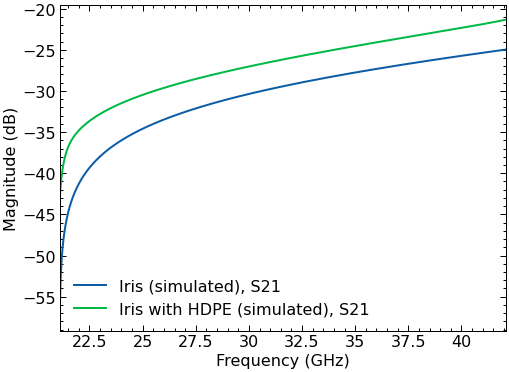

In [15]:
# Iris air:air (simulated)
iris_sim = rf.Network("iris.s2p")
iris_sim = iris_sim.interpolate(freq.f / 1e9)
iris_sim.name = "Iris (simulated)"

# Iris air:hdpe (simulated)
iris_sim_hdpe = rf.Network("iris-hdpe.s2p")
iris_sim_hdpe = iris_sim_hdpe.interpolate(freq.f / 1e9)
iris_sim_hdpe.name = "Iris with HDPE (simulated)"

# Plot
fig, ax = plt.subplots()
iris_sim.plot_s_db(1, 0, ax=ax)
iris_sim_hdpe.plot_s_db(1, 0, ax=ax)

# Waveguide Section

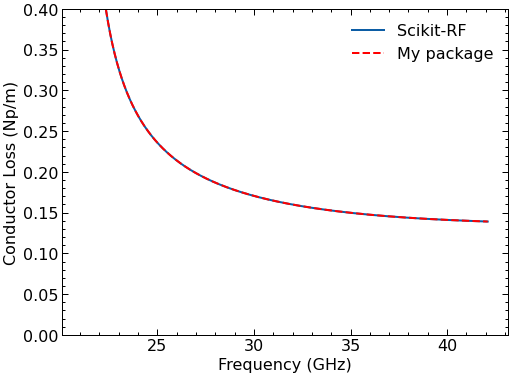

In [16]:
# Scikit-RF waveguides
wg_empty = RectangularWaveguide(freq, a=a, b=b, rho=1/cond)

# Plot
plt.figure()
plt.plot(f/1e9, wg_empty.alpha, label='Scikit-RF')
plt.plot(f/1e9, conductor_loss(f, cond, a, b, er=1, ur=1), 'r--', label='My package')
plt.ylabel("Conductor Loss (Np/m)")
plt.xlabel("Frequency (GHz)")
plt.ylim([0, 0.4])
plt.legend();

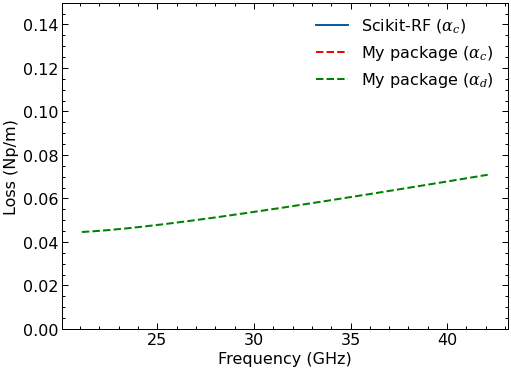

In [17]:
# Filled waveguide
wg_hdpe = RectangularWaveguide(freq, a=a, b=b, rho=1/cond, ep_r=er_mag)
alphac_skrf = wg_hdpe.alpha
# Note: skrf doesn't support loss dielectrics
alpha = wg_hdpe.alpha + dielectric_loss(f, a, b, er_mag * (1 - 1j * tand))
beta = wg_hdpe.beta
gamma = alpha + 1j*beta
wg_hdpe = DefinedGammaZ0(frequency=freq, z0=wg_hdpe.z0, gamma=gamma)

# Plot
plt.figure()
plt.plot(f/1e9, alphac_skrf, label=r'Scikit-RF ($\alpha_c$)')
alpha_c = conductor_loss(f, cond, a, b, er=er_mag, ur=1)
alpha_d = dielectric_loss(f, a, b, er=er, ur=1, m=1, n=0)
plt.plot(f/1e9, alpha_c, 'r--', label=r'My package ($\alpha_c$)')
plt.plot(f/1e9, alpha_d, 'g--', label=r'My package ($\alpha_d$)')
plt.ylabel("Loss (Np/m)")
plt.xlabel("Frequency (GHz)")
plt.ylim([0, 0.15])
plt.legend();

In [18]:
# 6 inch waveguides
wg_6in_empty = wg_empty.line(length, unit='m')
wg_6in_hdpe  = wg_hdpe.line(length, unit='m')
wg_6in_empty.name = "6\" waveguide (empty)"
wg_6in_hdpe.name = "6\" waveguide (HDPE)"

# Waveguide Cavity

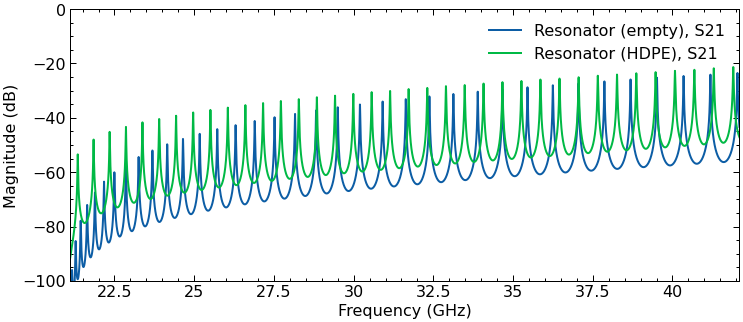

In [19]:
# Build resonators
resonator_empty = rf.connect(rf.connect(iris_sim,      1, wg_6in_empty, 0), 1, iris_sim,      1)
resonator_hdpe  = rf.connect(rf.connect(iris_sim_hdpe, 1, wg_6in_hdpe,  0), 1, iris_sim_hdpe, 1)
resonator_empty.name = "Resonator (empty)"
resonator_hdpe.name = "Resonator (HDPE)"

fig, ax = plt.subplots(figsize=(12,5))
resonator_empty.plot_s_db(1, 0, ax=ax)
resonator_hdpe.plot_s_db(1, 0, ax=ax)
ax.set_ylim([-100, 0]);

# Save Data

In [20]:
# Save data
meas1 = resonator_empty.copy()
meas2 = resonator_hdpe.copy()
meas1.write_touchstone("cavity.s2p")
meas2.write_touchstone("cavity-hdpe.s2p")